In [1]:
# ============================================================
# 1. Set up Spark Session
# ============================================================

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Seattle911")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/23 03:09:36 WARN Utils: Your hostname, Phongs-MacBook-Pro-23.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.46 instead (on interface en0)
25/11/23 03:09:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 03:09:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/23 03:09:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/23 03:09:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
# ============================================================
# 2. Data Import
# ============================================================

import os
from pathlib import Path

PROJECT_ROOT = Path("../../").resolve()

data_path = PROJECT_ROOT / "data" / "raw" / "Call_Data_20251019.csv"
out_path = PROJECT_ROOT / "data" / "processed" / "calldata_20251019_processed.parquet"
os.makedirs(out_path, exist_ok=True)

df = spark.read.csv(str(data_path), header=True, inferSchema=True)
#print(f"Loaded {df.count():,} rows with {len(df.columns)} columns")

In [3]:
# ============================================================
# 3. Clean Data
# ============================================================

from pyspark.sql import functions as F
from pyspark.sql import Window

# Select relevant columns

df = df.select('CAD Event Number','Call Type','Priority','Initial Call Type','Final Call Type',
               'CAD Event Original Time Queued','Dispatch Neighborhood',
               'Dispatch Sector','First SPD Call Sign Response Time (s)',
               'Count Of Officers')

# Turn 'First SPD Call Sign Response Time (s)','Count Of Officers' into numeric types
df = df.withColumn(
    "First SPD Call Sign Response Time (s)",
    F.regexp_replace(
        F.col("First SPD Call Sign Response Time (s)"),
        ",",
        ""
    ).cast("double")
)
df = df.withColumn('Count Of Officers', F.col('Count Of Officers').cast('integer')) 

# Remove rows with any null values in the selected columns

df = df.na.drop(subset=df.columns)


# Remove duplicate rows across all columns, keeping the first occurrence

df = df.distinct()

# Remove rows where there are still duplicate 'CAD Event Number' entries

window_spec = Window.partitionBy('CAD Event Number').orderBy('CAD Event Number')
df = df.withColumn('row_number', F.row_number().over(window_spec)).filter(F.col('row_number') == 1).drop('row_number') 

# Limit to Call Types = 911 only 

df = df.filter(F.col('Call Type') == '911')

# Clean Dispatch Sector and Dispatch Neighborhood columns 

df = df.filter((F.col('Dispatch Sector').isNotNull()) &
               (~F.col('Dispatch Sector').like("%REDACTED%")) & 
               (F.col('Dispatch Neighborhood').isNotNull()) &
               (~F.col('Dispatch Neighborhood').like("%REDACTED%")) & 
               (~F.col('Dispatch Neighborhood').like("-"))
               )

# Time conversions

df = (
    df
    .withColumn(
        "event_ts",
        F.to_timestamp(F.col("CAD Event Original Time Queued"), "MM/dd/yyyy hh:mm:ss a")
    )
    # date parts
    .withColumn("year",  F.year("event_ts"))
    .withColumn("month", F.month("event_ts"))
    .withColumn("day",   F.dayofmonth("event_ts"))
    # 1 = Sunday ... 7 = Saturday (Spark default)
    .withColumn("day_of_week", F.dayofweek("event_ts"))
    .withColumn("hour",  F.hour("event_ts"))
)

# Remove nan or negative values in 'First SPD Call Sign Response Time (s)'

df = df.filter(F.col("First SPD Call Sign Response Time (s)").isNotNull() &
               (F.col("First SPD Call Sign Response Time (s)") >= 0)
)   

# Outlier removal: First SPD Call Sign Response Time (s) IQR method

q1 = df.approxQuantile("First SPD Call Sign Response Time (s)", [0.25], 0.0)[0]
q3 = df.approxQuantile("First SPD Call Sign Response Time (s)", [0.75], 0.0)[0]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df.filter(
    (F.col("First SPD Call Sign Response Time (s)") >= lower_bound) &
    (F.col("First SPD Call Sign Response Time (s)") <= upper_bound)
)

In [4]:
# ============================================================
# 4. Feature Engineering for Call Data
# ============================================================


# Create column if nighttime (10pm-6am)

df = df.withColumn(
    "is_nighttime",
    F.when(
        (F.col("hour") >= 22) | (F.col("hour") <= 6),
        1
    ).otherwise(0)
)

# Create column if rush hour (7-9am, 4-6pm weekdays)

df = df.withColumn(
    "is_rush_hour",
    F.when(
        (F.col("day_of_week").between(2, 6)) & 
        ((F.col("hour").between(7, 9)) | (F.col("hour").between(16, 18))),
        1
    ).otherwise(0)
)

#  Numeric × Numeric Interactions 

def to_d(col):
    return F.col(col).cast("double")

df = (
    df.withColumn(
        "priority_x_officers",
        to_d("Priority") * to_d("Count Of Officers")
    )
    .withColumn(
        "priority_x_hour",
        to_d("Priority") * to_d("hour")
    )
)

In [5]:
df.select(F.max("event_ts")).show() # Check max timestamp

+-------------------+
|      max(event_ts)|
+-------------------+
|2025-10-15 23:55:48|
+-------------------+



In [6]:
df.select(F.min("event_ts")).show() # Check min timestamp

+-------------------+
|      min(event_ts)|
+-------------------+
|2010-01-01 00:03:12|
+-------------------+



In [7]:
# ============================================================
# 5. Join Weather Data
# ============================================================

weather = spark.read.parquet("../../data/raw/seattle_hourly_weather.parquet",header=True)

df_final = df.join(
    weather,
    on=[
        df.year  == weather.year,
        df.month == weather.month,
        df.day   == weather.day,
        df.hour  == weather.hour
    ],
    how="inner" 
)

# Keep only one of the duplicate columns after join
df_final = df_final.drop(weather.year).drop(weather.month).drop(weather.day).drop(weather.hour)

# Remove rows with TEMP, PRCP, COCO = NULL

df_final = df_final.filter(
    (F.col('TEMP').isNotNull()) &
    (F.col('PRCP').isNotNull()) &
    (F.col('COCO').isNotNull())
)  

# Cast COCO to integer

df_final = df_final.withColumn('COCO', F.col('COCO').cast('integer'))

In [8]:
# ============================================================
# 6. Feature Engineering for Weather Data
# ============================================================


# Map COCO values to weather intensity
#https://dev.meteostat.net/formats.html#meteorological-parameters

# Remove COCO = 0 (no weather)
df_final = df_final.filter(F.col("COCO") != 0)

# Complete COCO → Severity mapping (covers all codes 1–27)
severity_map = F.create_map(
    # Clear
    F.lit(1),  F.lit(0),
    F.lit(2),  F.lit(0),

    # Mild
    F.lit(3),  F.lit(1),
    F.lit(4),  F.lit(1),
    F.lit(5),  F.lit(1),

    # Snow / Ice – light/moderate
    F.lit(6),  F.lit(4),   # Freezing fog
    F.lit(10), F.lit(4),   # Freezing rain
    F.lit(12), F.lit(4),   # Sleet
    F.lit(14), F.lit(4),   # Light snowfall
    F.lit(15), F.lit(4),   # Snowfall
    F.lit(19), F.lit(4),   # Sleet shower
    F.lit(21), F.lit(4),   # Snow shower

    # Rain (normal)
    F.lit(7),  F.lit(2),   # Light rain
    F.lit(8),  F.lit(2),   # Rain
    F.lit(17), F.lit(2),   # Rain shower

    # Heavy rain
    F.lit(9),  F.lit(3),
    F.lit(18), F.lit(3),

    # Heavy snow / ice
    F.lit(11), F.lit(5),   # Heavy freezing rain
    F.lit(13), F.lit(5),   # Heavy sleet
    F.lit(16), F.lit(5),   # Heavy snowfall
    F.lit(20), F.lit(5),   # Heavy sleet shower
    F.lit(22), F.lit(5),   # Heavy snow shower

    # Storms
    F.lit(23), F.lit(6),   # Lightning
    F.lit(24), F.lit(6),   # Hail
    F.lit(25), F.lit(6),   # Thunderstorm
    F.lit(26), F.lit(6),   # Heavy thunderstorm
    F.lit(27), F.lit(6)    # Storm
)

df_final = df_final.withColumn("weather_severity", severity_map[F.col("COCO")])

# Create rain indicator

df_final = df_final.withColumn(
    "is_raining",
    F.when(F.col("PRCP") > 0, 1).otherwise(0)
)

#Create is freezing indicator

df_final = df_final.withColumn(
    "is_freezing",
    F.when(F.col("TEMP") <= 0, 1).otherwise(0)
)

25/11/23 03:10:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/23 03:10:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


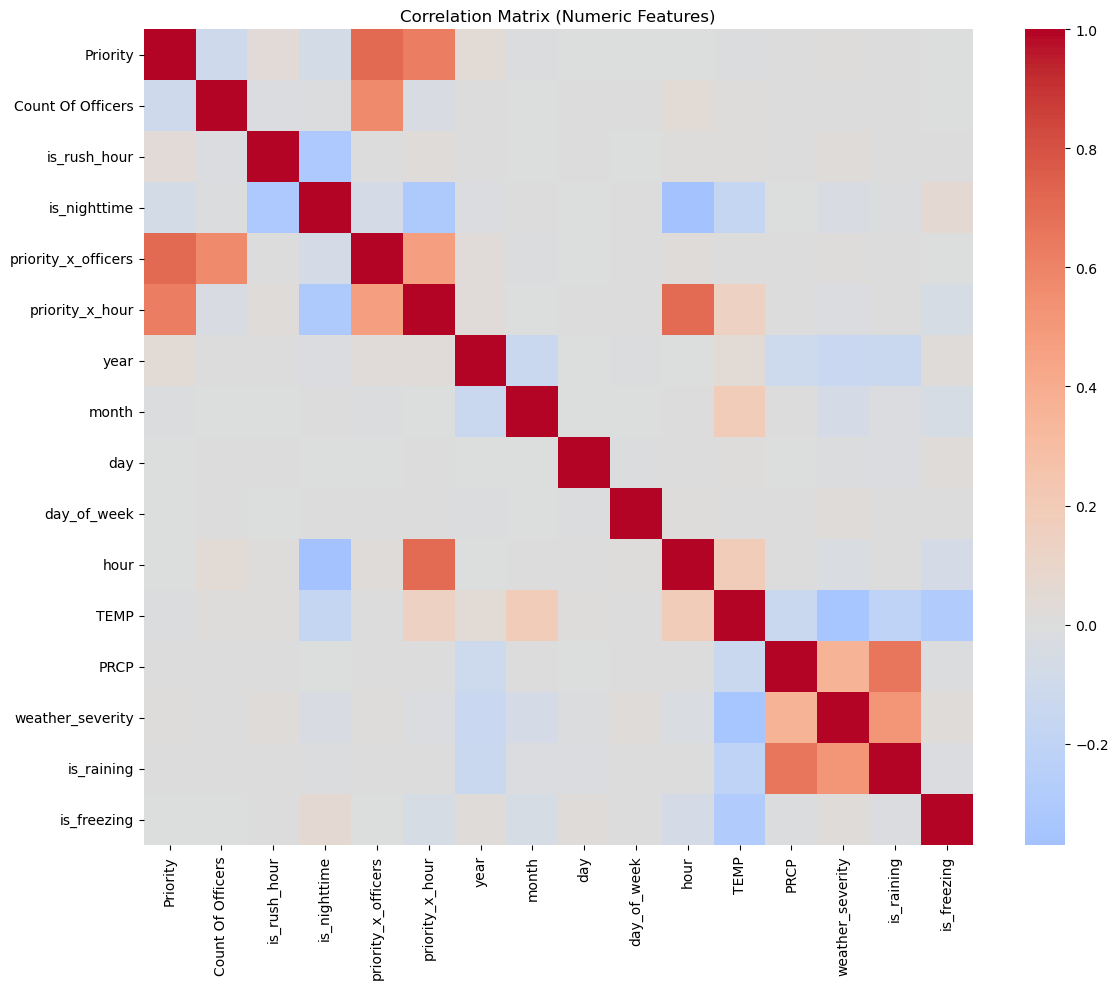

In [9]:
# ============================================================
# 7. Correlation Analysis
# ============================================================


from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

num_feats = [
    'Priority',
    'Count Of Officers',
    'is_rush_hour',
    'is_nighttime',
    'priority_x_officers',
    'priority_x_hour',
    'year',
    'month',
    'day',
    'day_of_week',
    'hour',
    'TEMP',
    'PRCP',
    'weather_severity',
    'is_raining',
    'is_freezing'
]

cat_feats = ["Call Type", "Dispatch Neighborhood", "Dispatch Sector"]

# Select only numeric columns (ensure they're double)
for c in num_feats:
    df_final = df_final.withColumn(c, F.col(c).cast("double"))
# Assemble into feature vector
assembler = VectorAssembler(inputCols=num_feats, outputCol="num_vector")
corr_df = assembler.transform(df_final).select("num_vector")

# Compute Pearson correlation matrix
corr_mat = Correlation.corr(corr_df, "num_vector", method="pearson").collect()[0][0]

# Convert to numpy / pandas for readability
import numpy as np
import pandas as pd

corr_array = np.array(corr_mat.toArray())
corr_pd = pd.DataFrame(corr_array, columns=num_feats, index=num_feats)


plt.figure(figsize=(12, 10))
sns.heatmap(corr_pd, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.savefig("../../figures/correlation_heatmap.png", dpi=500)
plt.show()

In [10]:
print(f"Final data: {df_final.count():,} rows with {len(df.columns)} columns")

Final data: 848,167 rows with 20 columns


In [11]:
# ============================================================
# 8. Write Processed Data
# ============================================================

df_final = df_final.select('CAD Event Number','Priority',
               'Dispatch Neighborhood','Dispatch Sector','First SPD Call Sign Response Time (s)',
               'Count Of Officers','is_rush_hour','is_nighttime',
               'priority_x_officers','priority_x_hour',
               'event_ts','year','month','day','day_of_week','hour', "TEMP", "PRCP", "COCO",
               'weather_severity','is_raining','is_freezing')
df_final.write.mode("overwrite").parquet(str(out_path))

In [12]:
spark.stop()